# Introduction
The original dataset deals with predicting whether a claim will be made on an insurance policy. Although the features are anonymized, they have properties relating to real-world features.

## Dataset Description
For this competition, you will predict whether a customer made a claim upon an insurance policy. The ground truth claim is binary valued, but a prediction may be any number from 0.0 to 1.0, representing the probability of a claim. The features in this dataset have been anonymized and may contain missing values.

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
#!unzip gdrive/My\ Drive/data/train.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold,RandomizedSearchCV,RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings # supress warnings
warnings.filterwarnings('ignore')


In [4]:
df  = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Tabular Playground Series/Sep 2021/train.csv')
df_actual = df.copy()

In [5]:
test  = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Tabular Playground Series/Sep 2021/train.csv')

In [7]:
df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957919 entries, 0 to 957918
Columns: 120 entries, id to claim
dtypes: float64(118), int64(2)
memory usage: 877.0 MB


# Checking imbalance

In [9]:
df['claim'].value_counts()

0    480404
1    477515
Name: claim, dtype: int64

Data is balanced

# Checking Missing value

In [10]:
missing_value = (df.isnull().sum()/len(df.index)).round(2)

In [11]:
type(missing_value)

pandas.core.series.Series

In [12]:
missing_value

id       0.00
f1       0.02
f2       0.02
f3       0.02
f4       0.02
         ... 
f115     0.02
f116     0.02
f117     0.02
f118     0.02
claim    0.00
Length: 120, dtype: float64

In [13]:
len(df.index)

957919

In [14]:
missing_value.to_csv("/gdrive/My Drive/Colab Notebooks/Tabular Playground Series/Sep 2021/miss.csv")


Looks like all features have missing values and missing values are of same count.

In [15]:
# Missing value imputation.We will use mean() value method to impute the values

In [6]:
df = df.fillna(df.mean())

In [17]:
#Checking missing value again
missing_value = (df.isnull().sum()/len(df.index)).round(2)
missing_value

id       0.0
f1       0.0
f2       0.0
f3       0.0
f4       0.0
        ... 
f115     0.0
f116     0.0
f117     0.0
f118     0.0
claim    0.0
Length: 120, dtype: float64

so, we do not have missing value now.

In [18]:
df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.100000,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.000000,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.200000,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.100000,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3959.204669,0.23049,1


## Lets check skewness in the data

In [19]:
df_skew = df.skew(axis=0,skipna= True)
df_skew = pd.DataFrame(df_skew)


In [20]:
df_skew

,0
id,-3.753145e-16
f1,-1.240534e-01
f2,-1.182571e+00
f3,2.242044e+00
f4,1.546599e+00
...,...
f115,1.577047e+00
f116,2.105910e+00
f117,7.023779e-01
f118,1.308262e+00


In [21]:
df_skew = df_skew.reset_index()
df_skew

,index,0
0,id,-3.753145e-16
1,f1,-1.240534e-01
2,f2,-1.182571e+00
3,f3,2.242044e+00
4,f4,1.546599e+00
...,...,...
115,f115,1.577047e+00
116,f116,2.105910e+00
117,f117,7.023779e-01
118,f118,1.308262e+00


In [22]:
df_skew.columns = ['feature','skew']
df_skew.head()

,feature,skew
0,id,-3.753145e-16
1,f1,-1.240534e-01
2,f2,-1.182571e+00
3,f3,2.242044e+00
4,f4,1.546599e+00


In [23]:
df_skew_not_acceptable = df_skew[(df_skew['skew'] < -1.5 ) | (df_skew['skew'] > 1.5 )]

In [24]:
df_skew_not_acceptable

,feature,skew
3,f3,2.242044
4,f4,1.546599
10,f10,2.913760
21,f21,1.988962
26,f26,2.137664
32,f32,2.045358
33,f33,1.734644
36,f36,1.540331
38,f38,1.518727
46,f46,-1.553526


In [25]:
len(df_skew_not_acceptable)

28

In [26]:
df_skew.to_csv("/gdrive/My Drive/Colab Notebooks/Tabular Playground Series/Sep 2021/skew.csv", index=False)


In [7]:
#lets remove skewness with paower transformation.(to remove both left and right skew)
pt = PowerTransformer(method = 'yeo-johnson', standardize=True)
df_pt = pt.fit_transform(df)
df_pt = pd.DataFrame(df_pt,columns = df.columns)
df_pt.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,-2.197134,0.413790,-1.810985,-0.655067,-1.151168,-0.297109,-5.018535,-1.234461,-0.544477,-0.516403,...,0.128866,-0.119430,-0.201821,-0.913952,-0.590702,0.197625,-0.522199,-1.369863,1.197355,1.003020
1,-2.196994,0.233730,-0.640268,1.220807,0.732438,1.236778,-0.353608,0.213534,-0.715242,0.873245,...,-1.581972,1.741998,-0.350420,0.329458,-0.656509,0.543922,-0.414515,-0.572454,-0.656033,-0.996989
2,-2.196874,2.082918,-1.831373,-0.427792,0.713185,1.234396,0.128853,0.611990,0.052248,-0.693303,...,0.721664,-1.405334,-0.361102,0.682945,-0.059303,-0.154220,-0.531820,0.089187,-0.220617,1.003020
3,-2.196766,1.456859,-1.805473,-0.452400,-1.062266,1.927085,3.477719,-1.268456,-0.251971,-0.660950,...,-0.958614,0.364861,-0.300090,-2.122364,-0.581003,-0.131870,-0.537994,0.401851,0.106497,1.003020
4,-2.196665,0.593629,1.473441,-0.716812,0.823020,0.139435,-0.148176,0.770038,-0.921939,0.105218,...,0.030127,-0.546698,-0.265933,-0.114649,-0.599728,2.004719,-0.543879,0.126236,-0.868261,1.003020


train_new_pt = pd.DataFrame(train_new_pt,columns = train.columns)
train_new_pt.head()

In [28]:
#checking skewness again after power transformation
df_skew = df_pt.skew(axis=0,skipna= True)
df_skew = pd.DataFrame(df_skew)
df_skew = df_skew.reset_index()
df_skew.columns = ['feature','skew']
df_skew_not_acceptable = df_skew[(df_skew['skew'] < -1.5 ) | (df_skew['skew'] > 1.5 )]
df_skew_not_acceptable

,feature,skew
53,f53,-1.730355
103,f103,-1.594304


We can see that , now we have no skewed data.

In [8]:
#Feature scaling
sc = StandardScaler()
df_scaled = sc.fit_transform(df_pt)
col = df_pt.columns
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = col
df_scaled.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,-2.197134,0.413790,-1.810985,-0.655067,-1.151168,-0.297109,-5.018535,-1.234461,-0.544477,-0.516403,...,0.128866,-0.119430,-0.201821,-0.913952,-0.590702,0.197625,-0.522199,-1.369863,1.197355,1.003020
1,-2.196994,0.233730,-0.640268,1.220807,0.732438,1.236778,-0.353608,0.213534,-0.715242,0.873245,...,-1.581972,1.741998,-0.350420,0.329458,-0.656509,0.543922,-0.414515,-0.572454,-0.656033,-0.996989
2,-2.196874,2.082918,-1.831373,-0.427792,0.713185,1.234396,0.128853,0.611990,0.052248,-0.693303,...,0.721664,-1.405334,-0.361102,0.682945,-0.059303,-0.154220,-0.531820,0.089187,-0.220617,1.003020
3,-2.196766,1.456859,-1.805473,-0.452400,-1.062266,1.927085,3.477719,-1.268456,-0.251971,-0.660950,...,-0.958614,0.364861,-0.300090,-2.122364,-0.581003,-0.131870,-0.537994,0.401851,0.106497,1.003020
4,-2.196665,0.593629,1.473441,-0.716812,0.823020,0.139435,-0.148176,0.770038,-0.921939,0.105218,...,0.030127,-0.546698,-0.265933,-0.114649,-0.599728,2.004719,-0.543879,0.126236,-0.868261,1.003020


In [9]:
df_scaled = df_scaled.drop(['id','claim'],axis =1)

In [31]:
#Applying PCA for important feature reduction
pca = PCA(random_state=42)
pca.fit_transform(df_scaled)

array([[ 0.50994246,  0.49734582, -0.93041346, ...,  0.4329798 ,
         0.57942667,  2.3378431 ],
       [-1.45172138, -1.46969394, -1.93955224, ..., -0.49067828,
         0.4912971 ,  1.32119667],
       [-0.09556943,  0.2871093 ,  1.05046485, ...,  0.89141149,
        -1.48228627,  0.54599024],
       ...,
       [-0.38541315,  1.434593  , -0.9770129 , ..., -1.83174532,
         0.04881547,  0.82083594],
       [-0.90853003,  1.4164791 , -0.37129088, ..., -0.09357305,
         1.04221612,  1.41362234],
       [-0.01134211,  2.33948992,  0.82841376, ..., -0.48869114,
         1.8224694 , -0.40983447]])

In [32]:
pca.explained_variance_ratio_

array([0.00968516, 0.0095362 , 0.00943291, 0.00927522, 0.00922565,
       0.00919152, 0.00915199, 0.00907864, 0.00906468, 0.00905759,
       0.0090136 , 0.00897875, 0.00894637, 0.00892482, 0.00890676,
       0.0088856 , 0.00888354, 0.00887504, 0.00885073, 0.00882361,
       0.0088053 , 0.0088002 , 0.00878816, 0.0087693 , 0.00875751,
       0.00873955, 0.00872934, 0.00872192, 0.00869971, 0.00867802,
       0.00866117, 0.00865303, 0.00863888, 0.00862901, 0.0086227 ,
       0.00861519, 0.00861122, 0.00860021, 0.0085912 , 0.00858867,
       0.00857357, 0.00857036, 0.00856347, 0.00856046, 0.00854969,
       0.00853945, 0.00853332, 0.0085237 , 0.00851229, 0.00850795,
       0.00850218, 0.00848594, 0.00848075, 0.00847799, 0.00847303,
       0.0084654 , 0.00845408, 0.00845089, 0.00843836, 0.00843621,
       0.00842269, 0.00841793, 0.00841109, 0.00840426, 0.00839971,
       0.00839001, 0.00838526, 0.00838133, 0.00837022, 0.00836896,
       0.00835878, 0.00835096, 0.00834448, 0.00834037, 0.00833

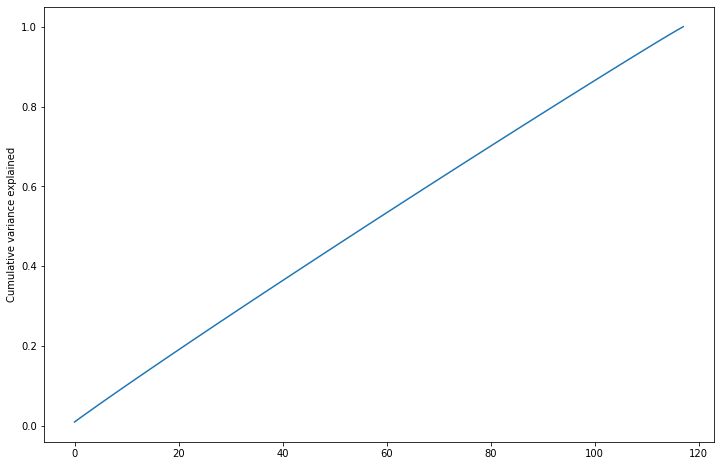

In [33]:
# Making a scree plot for the explained variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize = [12,8])
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [10]:
# Lets take 80 predictors to get at least 85 % of variance explained as per sree plot shown
pca = PCA(n_components=80,random_state=42)
df_scaled_pca=pca.fit_transform(df_scaled)

In [35]:
df_scaled_pca.shape

(957919, 80)

# Modelling

In [11]:
X = df_scaled_pca
y = df_actual['claim']

## Train-test splt

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify = y)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((766335, 80), (191584, 80), (766335,), (191584,))

## Logitic regression

In [13]:
lr = LogisticRegression()
lr.fit(X_train,y_train)


LogisticRegression()

In [14]:
y_pred_train = lr.predict_proba(X_train)
y_pred_test = lr.predict_proba(X_test)


In [40]:
y_test

465501    1
709698    0
600437    1
571033    0
363868    0
         ..
851571    1
676400    0
400715    1
806432    0
644420    1
Name: claim, Length: 191584, dtype: int64

In [41]:
type(y_test)

pandas.core.series.Series

In [15]:
# Converting y_test to dataframe
y_test = pd.DataFrame(y_test)
y_test.head()

,claim
465501,1
709698,0
600437,1
571033,0
363868,0


In [43]:
y_pred_test

array([[0.5015633 , 0.4984367 ],
       [0.4722901 , 0.5277099 ],
       [0.48531674, 0.51468326],
       ...,
       [0.53861415, 0.46138585],
       [0.49048962, 0.50951038],
       [0.51980146, 0.48019854]])

In [44]:
type(y_pred_test)

numpy.ndarray

In [16]:
# Converting y_pred to a dataframe which is an array
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test = y_pred_test.iloc[:,1]
y_pred_test.head()

0    0.498437
1    0.527710
2    0.514683
3    0.524435
4    0.555727
Name: 1, dtype: float64

In [46]:
print('roc-auc score ',metrics.roc_auc_score(y_test,y_pred_test))

roc-auc score  0.5408652591800513


In [ ]:
# Model tuing using cross valiadation
params = {'C':[0.1,0.01,1,10]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
Random_search = RandomizedSearchCV(estimator = lr, param_distributions=params, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = Random_search.fit(X_train,y_train)

In [ ]:
best_model = Random_search.best_estimator_
y_pred_train = best_model.predict_proba(X_train)
y_pred_test = best_model.predict_proba(X_test)


In [ ]:
# Converting y_test_pred to a dataframe which is an array
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test = y_pred_test.iloc[:,1]

In [ ]:
#print(metrics.roc_auc_score(y_train, y_pred_train))
print(metrics.roc_auc_score(y_test, y_pred_test))

0.5408653204266235


# XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)


XGBClassifier()

In [ ]:
y_pred_train = xgb.predict_proba(X_train)
y_pred_test = xgb.predict_proba(X_test)

In [ ]:
# Converting y_pred to a dataframe which is an array
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test = y_pred_test.iloc[:,1]
y_pred_test.head()

0    0.497352
1    0.514638
2    0.522767
3    0.519796
4    0.543364
Name: 1, dtype: float32

In [ ]:
#print(metrics.roc_auc_score(y_train, y_pred_train))
print(metrics.roc_auc_score(y_test, y_pred_test))

0.5406575641529484


## # Model tuing using cross valiadation

In [ ]:
# Lets find best parameter value with RandomizedSearchCV

params = {
    'n_estimators' : [5,10],
    'max_depth'    :[6,8],
    'learning_rate' : [0.2,0.3]
}

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=42)
Random_search = RandomizedSearchCV(estimator=xgb, param_distributions=params, cv=cv, scoring='roc_auc',error_score=0)
grid_result = Random_search.fit(X_train,y_train)

In [ ]:
best_model2 = Random_search.best_estimator_
y_pred_train = best_model2.predict_proba(X_train)
y_pred_test = best_model2.predict_proba(X_test)

# Converting y_test_pred to a dataframe which is an array
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test = y_pred_test.iloc[:,1]

In [ ]:
#print(metrics.roc_auc_score(y_train, y_pred_train))
print(metrics.roc_auc_score(y_test, y_pred_test))

# Test

In [17]:
# Perperfoming similar preprocessing on Test data as well
test = test.fillna(test.mean()) # Missing value treatment

#lets remove skewness with paower transformation.(to remove both left and right skew)
pt = PowerTransformer(method = 'yeo-johnson', standardize=True)
test_pt = pt.fit_transform(test)
test_pt = pd.DataFrame(test_pt,columns = test.columns)



In [ ]:
#Feature scaling
sc = StandardScaler()
test_scaled = sc.fit_transform(test_pt)
col = test_pt.columns
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = col

test_scaled = test_scaled.drop(['id'],axis =1)

In [ ]:

#Applying PCA for important feature reduction
pca = PCA(random_state=42)
pca.fit_transform(test_scaled)

# Lets take 80 predictors to get at least 85 % of variance explained as per sree plot shown
pca = PCA(n_components=80,random_state=42)
test_scaled_pca=pca.fit_transform(test_scaled)

Prediction on Test data

In [ ]:
X_test = test_scaled_pca

In [ ]:
best_model2 = Random_search.best_estimator_

y_pred_test = best_model2.predict_proba(X_test)

# Converting y_test_pred to a dataframe which is an array
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test = y_pred_test.iloc[:,1]

In [ ]:
#print(metrics.roc_auc_score(y_train, y_pred_train))
print(metrics.roc_auc_score(y_test, y_pred_test))

# Submission

In [18]:
submission = pd.DataFrame(test['id'])
submission['claim'] = y_pred_test

In [19]:
submission.to_csv('/gdrive/My Drive/Colab Notebooks/Tabular Playground Series/Sep 2021/Final_submission.csv',index=False)

In [21]:
submission.head()

,id,claim
0,0,0.498437
1,1,0.527710
2,2,0.514683
3,3,0.524435
4,4,0.555727
